In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time
from pathlib import Path

from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd

from tqdm import tqdm_notebook

In [11]:
import pymc3 as pm

/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["font.family"] = "IPAexGothic"
import logging
logging.basicConfig(level=logging.INFO)

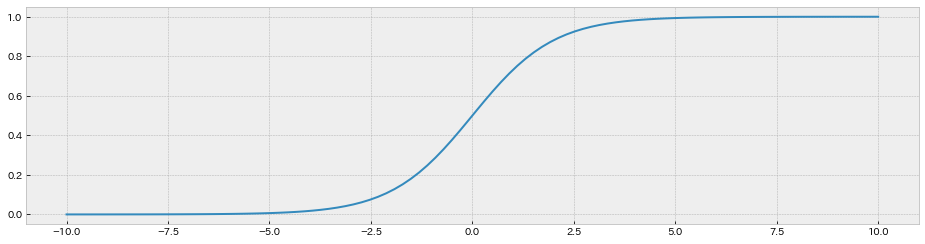

In [3]:
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))
plt.plot(z, logistic)

In [4]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


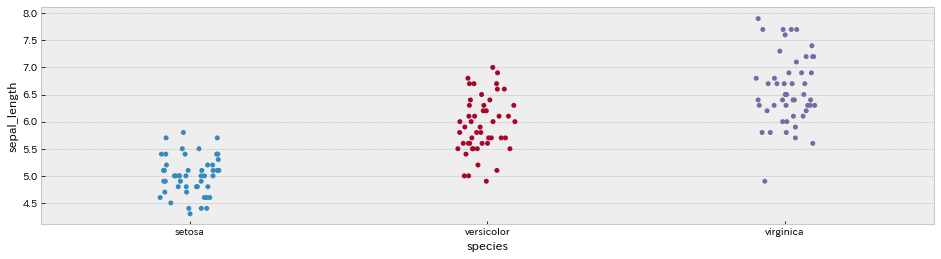

In [5]:
sns.stripplot(x='species', y='sepal_length', data=iris, jitter=True)

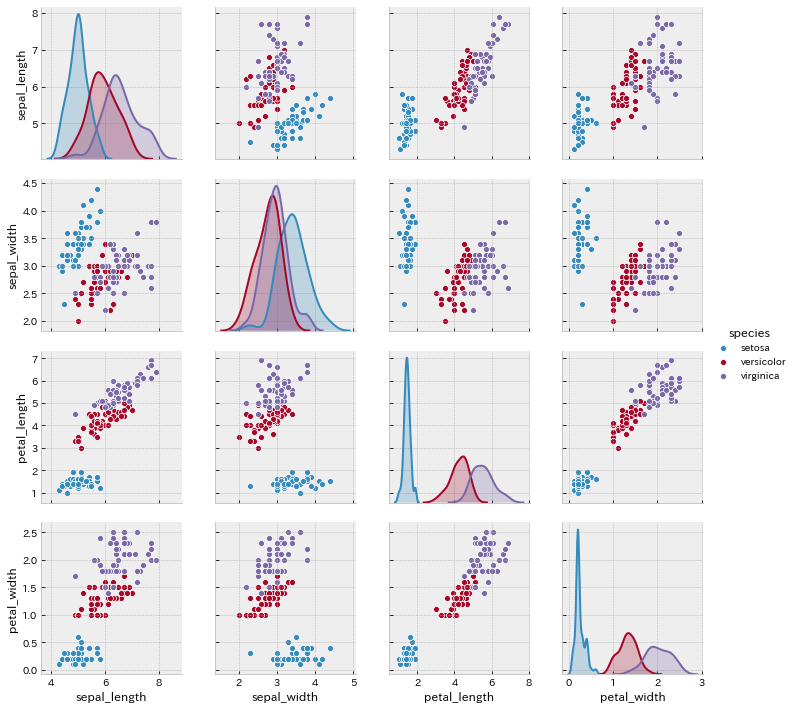

In [6]:
sns.pairplot(iris, hue='species', diag_kind='kde')

In [7]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values

In [10]:
y_0, x_n, x_0

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8),
 'sepal_length',
 array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
        4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
        5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
        5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
        6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
        6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
        6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
        6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7]))

In [12]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_0, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd', -alpha / beta)
    
    y_1 = pm.Bernoulli('y_1', p=theta, observed=y_0)
    trace = pm.sample(5000)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:18<00:00, 585.24draws/s]
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1150bcd30>,
      dtype=object)

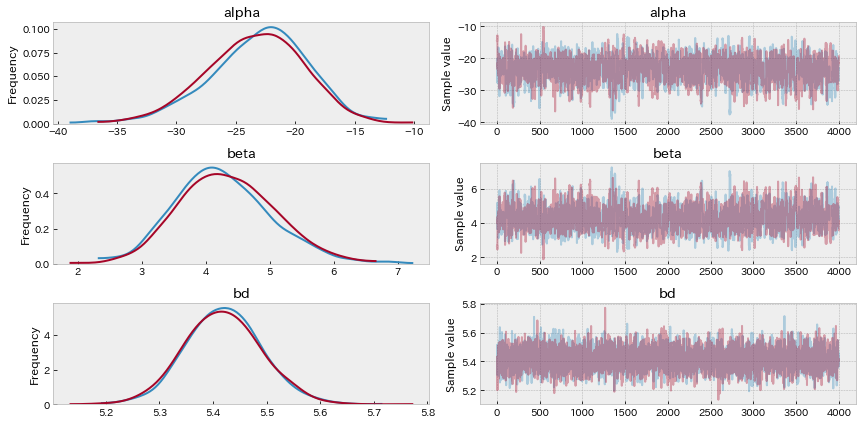

In [13]:
chain = trace[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain, varnames)

In [14]:
pm.summary(chain, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-23.259467,4.074984,0.125849,-31.714580,-15.997049,1116.740864,1.001784
beta,4.293375,0.754262,0.023403,2.897284,5.819390,1115.535849,1.001913
bd,5.418372,0.070237,0.000884,5.278810,5.555810,6300.450448,1.000293


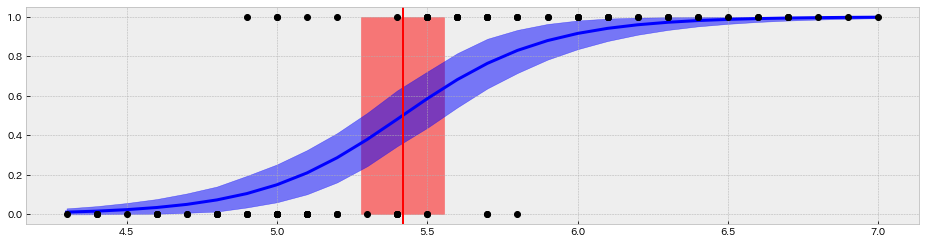

In [18]:
theta = chain['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3)
plt.axvline(chain['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(chain['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=.5)
plt.plot(x_0, y_0, 'o', color='k')

theta_hpd = pm.hpd(chain['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:, 0], theta_hpd[:, 1], color='b', alpha=.5)


In [20]:
def classify(n, threshold, chain):
    n = np.array(n)
    mu = chain['alpha'].mean() + chain['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob >= threshold

In [22]:
classify([5, 5.5, 6], .5, chain)

(array([0.14275533, 0.58761059, 0.92419676]), array([False,  True,  True]))

In [23]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_1 = df[x_n].values

In [24]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    mu = alpha + pm.math.dot(x_1, beta)
    
    theta = 1 / (1 + pm.math.exp(-mu))
    bd = pm.Deterministic('bd', -alpha / beta[1]- beta[0] / beta[1] * x_1[:, 0])
    y_1_ = pm.Bernoulli('y_1', p=theta, observed=y_1)
    
    trace = pm.sample(5000)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:25<00:00, 434.60draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116a5e3c8>,
      dtype=object)

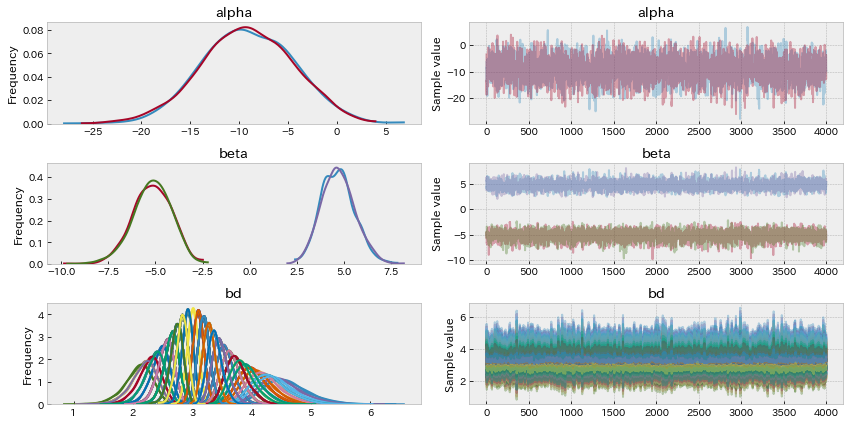

In [25]:
chain = trace[1000:]
pm.traceplot(chain, varnames)

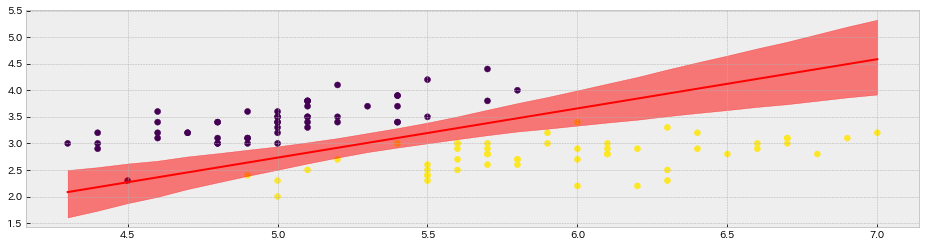

In [27]:
idx = np.argsort(x_1[:, 0])
ld = chain['bd'].mean(0)[idx]
plt.scatter(x_1[:, 0], x_1[:, 1], c=y_0, cmap='viridis')
plt.plot(x_1[:, 0][idx], ld, color='r')

ld_hpd = pm.hpd(chain['bd'])[idx]
plt.fill_between(x_1[:, 0][idx], ld_hpd[:, 0], ld_hpd[:, 1], color='r', alpha=.5)

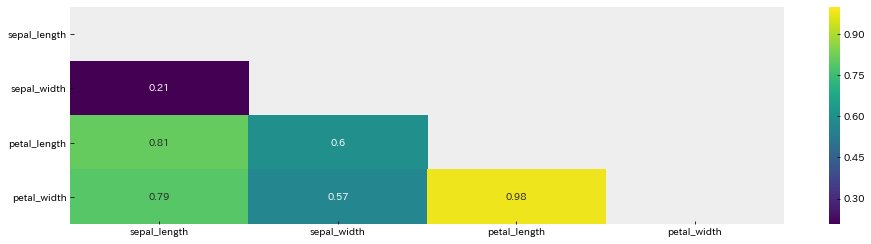

In [31]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')

In [33]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_3 = df[x_n].values

In [34]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    mu = alpha + pm.math.dot(x_3, beta)
    
    theta = 1 / (1 + pm.math.exp(-mu))
    bd = pm.Deterministic('bd', -alpha / beta[1]- beta[0] / beta[1] * x_3[:, 0])
    y_3_ = pm.Bernoulli('y_3', p=theta, observed=y_3)
    
    trace = pm.sample(5000)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:24<00:00, 452.94draws/s]
ERROR:pymc3:There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
chain = trace[1000:]

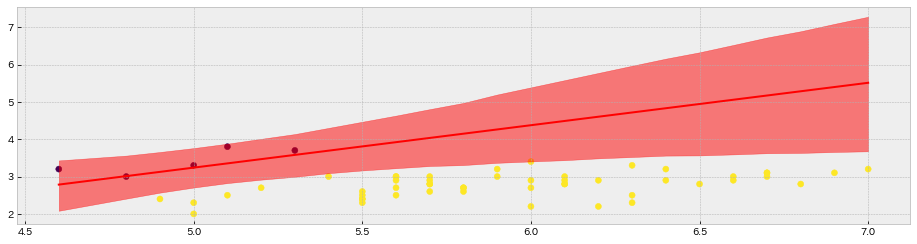

In [38]:
idx = np.argsort(x_3[:, 0])
ld = chain['bd'].mean(0)[idx]
plt.scatter(x_3[:, 0], x_3[:, 1], c=y_3, cmap='viridis')
plt.plot(x_3[:, 0][idx], ld, color='r')

ld_hpd = pm.hpd(chain['bd'])[idx]
plt.fill_between(x_3[:, 0][idx], ld_hpd[:, 0], ld_hpd[:, 1], color='r', alpha=.5)

In [56]:
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [57]:
import theano.tensor as tt

In [60]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4, 3))
    mu = alpha + pm.math.dot(x_s, beta)
    theta = tt.nnet.softmax(mu)
    yl = pm.Categorical('yl', p=theta, observed=y_s)
    trace = pm.sample(2000)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:16<00:00, 311.57draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1166c5860>,
      dtype=object)

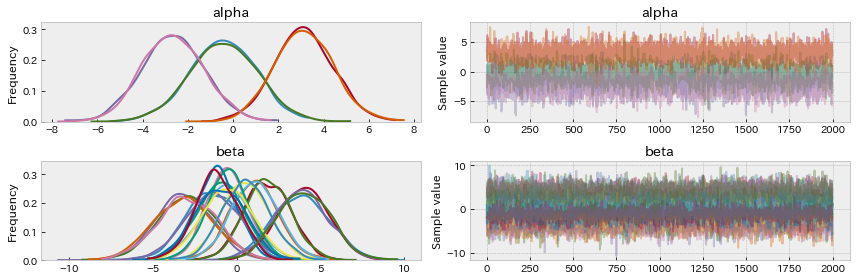

In [61]:
pm.traceplot(trace)

In [63]:
data_pred = trace['alpha'].mean(0) + np.dot(x_s, trace['beta'].mean(0))
y_pred = []
for point in data_pred:
    y_pred.append(np.exp(point) / np.sum(np.exp(point), axis=0))
np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s)

0.9733333333333334

In [64]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4, 3))
    alpha_f = tt.concatenate([[0], alpha])
    beta_f = tt.concatenate([np.zeros((4, 1)), beta], axis=1)
    mu = alpha_f + pm.math.dot(x_s, beta_f)
    theta = tt.nnet.softmax(mu)
    yl = pm.Categorical('yl', p=theta, observed=y_s)
    trace = pm.sample(2000)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:16<00:00, 294.82draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11919ccf8>,
      dtype=object)

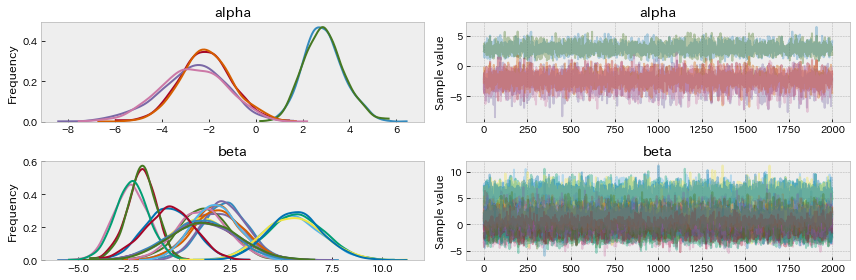

In [65]:
pm.traceplot(trace)

In [68]:
with pm.Model() as model:
    mus = pm.Normal('mus', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)
    setosa = pm.Normal('setosa', mu=mus[0], sd=sigma, observed=x_0[:50])
    ver = pm.Normal('ver', mu=mus[1], sd=sigma, observed=x_0[:50])
    bd = pm.Deterministic('bd', (mus[0]+mus[1]) / 2)
    trace = pm.sample(5000)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:NUTS: [sigma, mus]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:05<00:00, 2129.59draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119732198>,
      dtype=object)

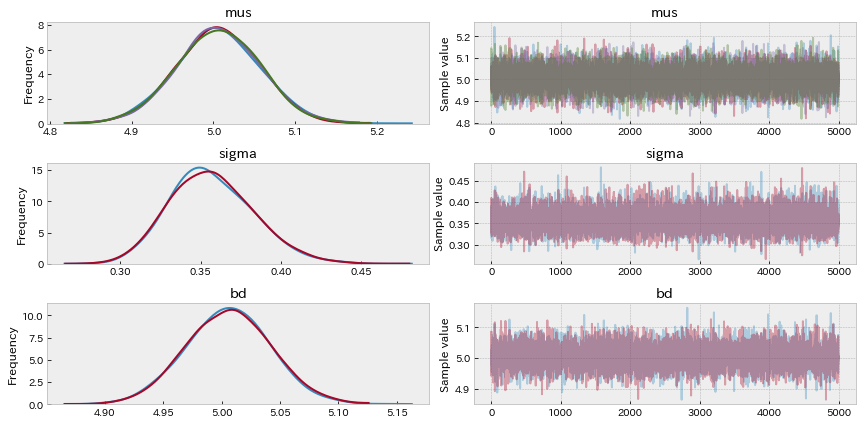

In [69]:
pm.traceplot(trace)

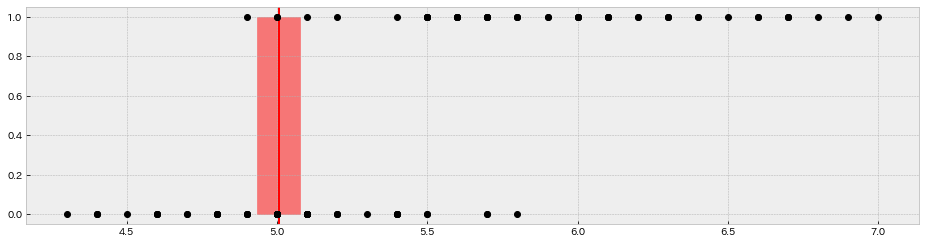

In [71]:
# theta = chain['theta'].mean(axis=0)
# idx = np.argsort(x_0)
# plt.plot(x_0[idx], theta[idx], color='b', lw=3)
plt.axvline(trace['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=.5)
plt.plot(x_0, y_0, 'o', color='k')

In [72]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mus__0,5.006242,0.051032,0.000471,4.900962,5.100588,12342.188977,0.999954
mus__1,5.005840,0.050275,0.000409,4.907680,5.103955,13383.317529,0.999908
sigma,0.357145,0.025965,0.000228,0.308672,0.408816,11312.368586,0.999925
bd,5.006041,0.036081,0.000328,4.935053,5.076258,12178.385009,0.999952
